In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.25, 1)

Removed 19 outliers from 968 observations. Percentage: 1.96%


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-18 16:58:10,079] A new study created in memory with name: no-name-12377c72-89f3-48e4-a655-436da9eaac97
[I 2025-04-18 16:58:15,758] Trial 0 finished with value: 0.7340586334466934 and parameters: {'hidden_dim': 60, 'id_embed_dim': 8, 'lr': 0.002592281317321675, 'batch_size': 64, 'alpha': 0.20320930401716364}. Best is trial 0 with value: 0.7340586334466934.
[I 2025-04-18 16:58:15,942] Trial 1 finished with value: 0.8947119861841202 and parameters: {'hidden_dim': 101, 'id_embed_dim': 5, 'lr': 0.0005991287825388612, 'batch_size': 32, 'alpha': 0.2272982415687634}. Best is trial 0 with value: 0.7340586334466934.
[I 2025-04-18 16:58:16,036] Trial 2 finished with value: 0.7086691856384277 and parameters: {'hidden_dim': 86, 'id_embed_dim': 10, 'lr': 0.008837554845971044, 'batch_size': 128, 'alpha': 0.1935049821736441}. Best is trial 2 with value: 0.7086691856384277.
[I 2025-04-18 16:58:16,220] Trial 3 finished with value: 0.6934059709310532 and parameters: {'hidden_dim': 112, 'id_emb

Best hyperparams: {'hidden_dim': 108, 'id_embed_dim': 14, 'lr': 0.0045497638395559075, 'batch_size': 128, 'alpha': 0.010144583780345379}


In [6]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [7]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)

Epoch 1: train loss = 0.4581, val loss = 0.3782
Epoch 2: train loss = 0.2933, val loss = 0.2096
Epoch 3: train loss = 0.1503, val loss = 0.1210
Epoch 4: train loss = 0.0937, val loss = 0.0903
Epoch 5: train loss = 0.0682, val loss = 0.0780
Epoch 6: train loss = 0.0574, val loss = 0.0729
Epoch 7: train loss = 0.0513, val loss = 0.0684
Epoch 8: train loss = 0.0473, val loss = 0.0655
Epoch 9: train loss = 0.0444, val loss = 0.0626
Epoch 10: train loss = 0.0423, val loss = 0.0616
Epoch 11: train loss = 0.0408, val loss = 0.0603
Epoch 12: train loss = 0.0394, val loss = 0.0602
Epoch 13: train loss = 0.0377, val loss = 0.0601
Epoch 14: train loss = 0.0368, val loss = 0.0603
Epoch 15: train loss = 0.0356, val loss = 0.0597
Epoch 16: train loss = 0.0347, val loss = 0.0601
Epoch 17: train loss = 0.0331, val loss = 0.0625
Epoch 18: train loss = 0.0322, val loss = 0.0608
Epoch 19: train loss = 0.0309, val loss = 0.0626
Epoch 20: train loss = 0.0296, val loss = 0.0627
Epoch 21: train loss = 0.0285

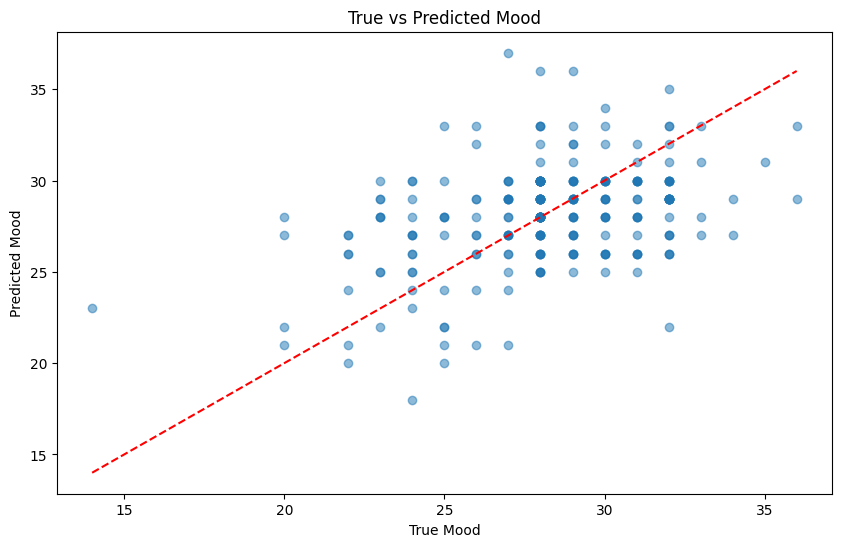

In [8]:
plot_mood_predictions(model, val_loader, device)

In [9]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

Accuracy: 0.1562


In [10]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    24
1   AS14.02                    27
2   AS14.03                    25
3   AS14.05                    33
4   AS14.06                    36
5   AS14.07                    27
6   AS14.08                    20
7   AS14.09                    23
8   AS14.12                    25
9   AS14.13                    27
10  AS14.14                    32
11  AS14.15                    25
12  AS14.16                    20
13  AS14.17                    25
14  AS14.19                    25
15  AS14.20                    23
16  AS14.23                    26
17  AS14.24                    27
18  AS14.25                    27
19  AS14.26                    27
20  AS14.27                    25
21  AS14.28                    26
22  AS14.29                    25
23  AS14.30                    23
24  AS14.31                    32
25  AS14.32                    23
26  AS14.33                    27


In [11]:
train_df_split = train_df_split.sort_values('mood')
train_df_split['mood'].unique(), train_df_split['mood'].value_counts()

(array([12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 38], dtype=int32),
 mood
 28    168
 29     84
 32     72
 26     71
 30     70
 31     61
 27     53
 25     37
 24     32
 33     14
 22      7
 34      6
 23      6
 21      5
 35      4
 14      2
 20      2
 18      2
 36      1
 12      1
 19      1
 16      1
 38      1
 Name: count, dtype: int64)